# IMports

In [73]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras import layers

# Load Data

In [74]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df = df.sample(n=5000).reset_index(drop=True)
df.head()

,review,sentiment
0,Felt it was very balanced in showing what Jeho...,positive
1,Charlotte Beal arrives at an isolated country ...,positive
2,After having seen a lot of Greek movies I feel...,positive
3,"Before I speak my piece, I would like to make ...",negative
4,"a timeless classic, wonderfully acted with per...",positive


# Preprocess text

In [75]:
import re
import html
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (only the first time)
nltk.download('stopwords')

# Initialize the stemmer and stopwords list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_review_with_stopwords_and_stemming(review):
    # Decode HTML entities (like <br /> to actual line breaks)
    review = html.unescape(review)

    # Remove HTML tags (e.g., <br />)
    review = re.sub(r'<.*?>', '', review)

    # Convert to lowercase
    review = review.lower()

    # Remove non-alphabetic characters and digits
    review = re.sub(r'[^a-z\s]', '', review)

    # Tokenization: Split the review into words
    words = review.split()

    # Remove stopwords and apply stemming
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]

    # Rejoin the words back into a cleaned string
    cleaned_review = ' '.join(cleaned_words)

    return cleaned_review

# Example usage on your dataset
import pandas as pd

# Assuming df is your DataFrame with reviews
df['review'] = df['review'].apply(clean_review_with_stopwords_and_stemming)

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review,sentiment
0,felt balanc show jehovah wit done protect amer...,positive
1,charlott beal arriv isol countri mental hospit...,positive
2,seen lot greek movi feel suspici watch felt as...,positive
3,speak piec would like make thing clear chick w...,negative
4,timeless classic wonder act perfect locat set ...,positive
...,...,...
4995,tri finish film three time god aw case point m...,negative
4996,footprint interest movi somewhat difficult cat...,positive
4997,plot manipul count complet uncred unthink deci...,negative
4998,present shabbi notion documentari often michae...,negative


# Encoding

In [76]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])
df

,review,sentiment
0,felt balanc show jehovah wit done protect amer...,1
1,charlott beal arriv isol countri mental hospit...,1
2,seen lot greek movi feel suspici watch felt as...,1
3,speak piec would like make thing clear chick w...,0
4,timeless classic wonder act perfect locat set ...,1
...,...,...
4995,tri finish film three time god aw case point m...,0
4996,footprint interest movi somewhat difficult cat...,1
4997,plot manipul count complet uncred unthink deci...,0
4998,present shabbi notion documentari often michae...,0


# Train Test Split

In [77]:
RANDOM_STATE = 42
text_train, text_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=RANDOM_STATE)

# Tokenization

In [78]:
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

X_train = tokenizer.texts_to_sequences(text_train)
X_test = tokenizer.texts_to_sequences(text_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
maxlen = max(len(x) for x in X_train) # longest text in train set

# Add padding to ensure all vectors have the same dimensionality
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [79]:
X_train

array([[ 218,  257,  166, ...,    0,    0,    0],
       [1055, 2297, 2753, ...,    0,    0,    0],
       [   4,    1,  128, ...,    0,    0,    0],
       ...,
       [  73,  577,  399, ...,    0,    0,    0],
       [1129, 1232,   11, ...,    0,    0,    0],
       [2294, 8100, 3314, ...,    0,    0,    0]], dtype=int32)

In [80]:
y_train

,sentiment
3716,0
3779,1
135,1
4480,1
1437,1
...,...
4426,1
466,0
3092,1
3772,1


# CNN Architecture

In [87]:
# Define CNN model
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [88]:
# Fit the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=64,
                    verbose=True,
                    validation_data=(X_test, y_test))

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 483ms/step - accuracy: 0.5753 - loss: 0.6915 - val_accuracy: 0.6740 - val_loss: 0.6055
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 50s 605ms/step - accuracy: 0.7800 - loss: 0.5216 - val_accuracy: 0.8460 - val_loss: 0.3672
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 71s 457ms/step - accuracy: 0.9329 - loss: 0.2257 - val_accuracy: 0.8540 - val_loss: 0.3537
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 450ms/step - accuracy: 0.9880 - loss: 0.0621 - val_accuracy: 0.8320 - val_loss: 0.4047
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 452ms/step - accuracy: 0.9996 - loss: 0.0134 - val_accuracy: 0.8300 - val_loss: 0.4436


# Visualize accuracy

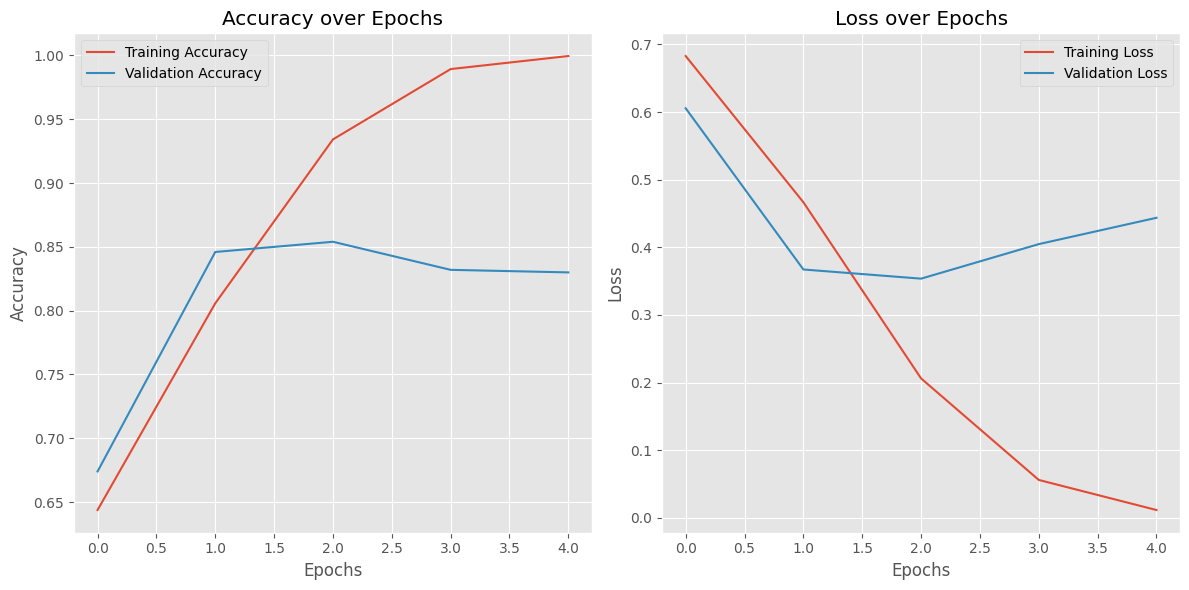

In [89]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


# Confusion and Classification Report

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       240
           1       0.83      0.85      0.84       260

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



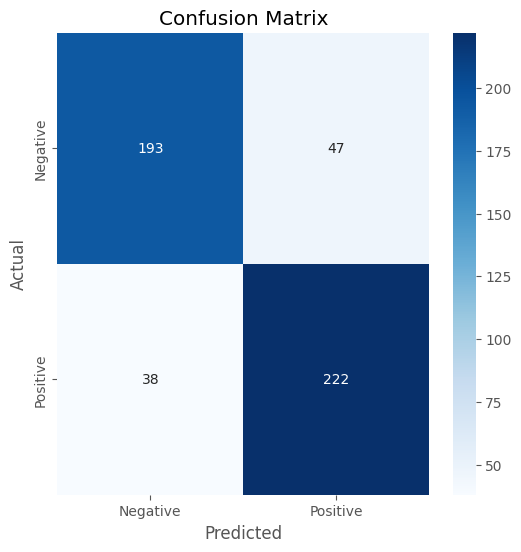

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Predict script

In [91]:
def predict_sentiment(text, tokenizer, model, maxlen):
    # clean text
    text = clean_review_with_stopwords_and_stemming(text)
    # Tokenize the text and convert to sequence of indices
    sequence = tokenizer.texts_to_sequences([text])

    # Pad the sequence to ensure it has the same length as the input data
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=maxlen)

    # Predict the sentiment
    prediction = model.predict(padded_sequence)

    # Convert prediction to a readable sentiment
    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"

In [92]:
# Example usage:
input_text = "I loved this movie, it was amazing!"
predicted_sentiment = predict_sentiment(input_text, tokenizer, model, maxlen)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted Sentiment: Positive


In [93]:
# Example usage:
input_text = "I hated this movie, it was bad!"
predicted_sentiment = predict_sentiment(input_text, tokenizer, model, maxlen)
print(f"Predicted Sentiment: {predicted_sentiment}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Sentiment: Negative


# Save Model, Tokenizer

In [95]:
import pickle
# Save the trained model
model.save('sentiment_model.h5')

# Save the tokenizer using pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)